
=== Episode 1 ===
Initial Batteries:
MDs: [3415 3954 4068]
ESs: [12219 13880]
Task 1 (382MB) - Device: ES0
  Energy used: 155.9mAh
  MD0 battery: 3376.0mAh
  ES0 battery: 12101.0mAh
Task 2 (165MB) - Device: ES0
  Energy used: 67.4mAh
  MD0 battery: 3359.0mAh
  ES0 battery: 12050.0mAh
Task 3 (264MB) - Device: ES1
  Energy used: 119.2mAh
  MD0 battery: 3332.0mAh
  ES1 battery: 13787.0mAh
Task 4 (395MB) - Device: MD0
  Energy used: 384.2mAh
  MD0 battery: 2947.0mAh
Task 5 (358MB) - Device: ES1
  Energy used: 161.6mAh
  MD0 battery: 2910.0mAh
  ES1 battery: 13661.0mAh
Task 6 (334MB) - Device: MD1
  Energy used: 288.1mAh
  MD1 battery: 3665.0mAh
Task 7 (150MB) - Device: ES1
  Energy used: 67.7mAh
  MD0 battery: 2894.0mAh
  ES1 battery: 13608.0mAh
Task 8 (320MB) - Device: MD2
  Energy used: 429.7mAh
  MD2 battery: 3638.0mAh
Task 9 (215MB) - Device: ES0
  Energy used: 117.3mAh
  MD1 battery: 3613.0mAh
  ES0 battery: 11984.0mAh
Task 10 (457MB) - Device: ES1
  Energy used: 269.1mAh
  MD1 batte

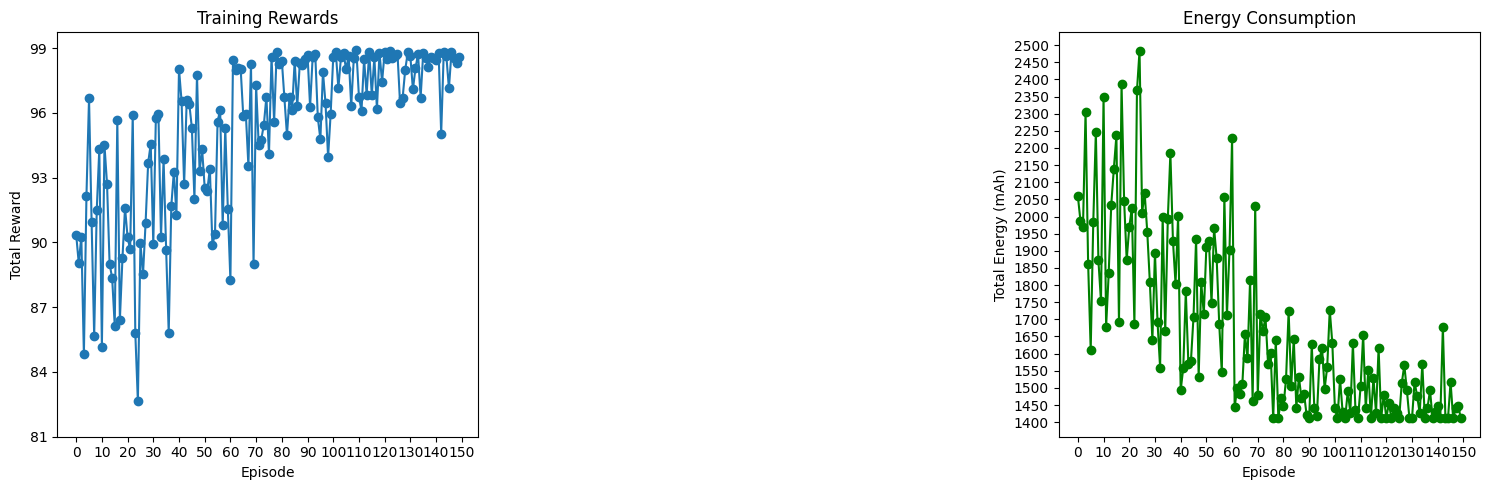

In [6]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# -------------------------------
# Prioritized Replay Buffer (Fixed)
# -------------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.4):  # Reduced alpha for less prioritization
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-0.5)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

# -------------------------------------------
# Mobile Edge Computing Environment (Updated)
# -------------------------------------------
class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=20):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        
        # Mobile Devices (MD) parameters
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)        # GHz
        self.md_battery = np.random.randint(3000, 5001, num_md)      # mAh
        self.md_energy_local = np.random.uniform(1000, 3000, num_md) # mA/s (processing)
        self.md_energy_tx = np.random.uniform(0.1, 0.3, num_md)      # mAh per MB (transmission)
        
        # Edge Servers (ES) parameters
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)        # GHz
        self.es_battery = np.random.randint(10000, 20001, num_es)    # mAh
        self.es_energy_process = np.random.uniform(500, 1500, num_es) # mA/s (processing)
        
        # Task parameters
        self.task_requirements = np.random.randint(100, 501, num_tasks)  # MB
        self.task_to_md = np.random.randint(0, num_md, num_tasks)  # Assign tasks to MDs
        
        self.reset()

    def reset(self):
        # Reset batteries to initial values
        self.md_battery = np.random.randint(3000, 5001, self.num_md)
        self.es_battery = np.random.randint(10000, 20001, self.num_es)
        
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size)
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        # Normalize values
        state = [
            self.md_battery[md_idx] / 5000,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / 3000,
            self.md_energy_tx[md_idx] / 0.3
        ]
        
        # Add ES parameters
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / 20000,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / 1500
            ])
        
        # Add task progress
        state.append(self.current_task / self.num_tasks)
        
        self.state_size = len(state)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size), 0, True, {}
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        reward = 0
        done = False
        success = False
        device_used = ""
        energy_consumed = 0
        
        # Capture initial battery states
        initial_md_battery = self.md_battery[md_idx]
        initial_es_battery = self.es_battery[action-1] if action != 0 else 0

        # Process current task
        if action == 0:  # Local processing
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.md_compute[md_idx] * 1e9)  # Seconds
            energy_needed = processing_time * self.md_energy_local[md_idx]  # mA
            
            if initial_md_battery >= energy_needed:
                # Successful local processing
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                
                # Reward components
                task_value = (task_size / 500) * 15  # Base reward scaled by task size
                energy_efficiency = (energy_needed / task_size) * 3  # Penalize energy per MB
                battery_impact = (energy_needed / initial_md_battery) * 8  # Penalize battery drain
                
                reward = task_value - energy_efficiency - battery_impact
                success = True
                energy_consumed = energy_needed
                device_used = f"MD{md_idx}"
            else:
                # Failed local processing
                self.violations += 1
                reward = -(task_size / 500) * 15  # Penalty proportional to task size
                self.md_battery[md_idx] = 0
        else:  # Offload to ES
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1
                
            # Transmission energy (per-MB rate)
            tx_energy = task_size * self.md_energy_tx[md_idx]
            
            # Edge processing (time-based)
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.es_compute[es_idx] * 1e9)  # Seconds
            process_energy = processing_time * self.es_energy_process[es_idx]  # mA
            
            if (initial_md_battery >= tx_energy and 
                self.es_battery[es_idx] >= process_energy):
                
                # Successful offload
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1

                # Reward components
                task_value = (task_size / 500) * 15
                total_energy = tx_energy + process_energy
                energy_efficiency = (total_energy / task_size) * 2.5
                md_impact = (tx_energy / initial_md_battery) * 5
                es_impact = (process_energy / self.es_battery[es_idx]) * 5
                
                reward = task_value - energy_efficiency - md_impact - es_impact
                success = True
                energy_consumed = total_energy
                device_used = f"ES{es_idx}"
            else:
                # Failed offload
                self.violations += 1
                reward = -(task_size / 500) * 15
                if self.md_battery[md_idx] < tx_energy:
                    self.md_battery[md_idx] = 0
                if self.es_battery[es_idx] < process_energy:
                    self.es_battery[es_idx] = 0
        
        # Print step details
        print(f"Task {self.current_task+1} ({task_size}MB) - Device: {device_used if success else 'None'}")
        if success:
            print(f"  Energy used: {energy_consumed:.1f}mAh")
            print(f"  MD{md_idx} battery: {self.md_battery[md_idx]:.1f}mAh")
            if action != 0:
                print(f"  ES{es_idx} battery: {self.es_battery[es_idx]:.1f}mAh")
        else:
            print("  Failed - insufficient battery")
        
        # Move to next task
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        
        # Get next state
        next_state = self._get_state()
        
        # Episode completion bonus
        if done:
            completion_ratio = self.completed_tasks / self.num_tasks
            reward += completion_ratio * 20  # Scaled completion bonus
            reward -= (self.violations / self.num_tasks) * 25  # Scaled violation penalty
        
        return next_state, reward, done, {}

# -------------------------------
# Dueling DQN Agent (Updated with Regularization)
# -------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(50000)  # Increased buffer size
        self.batch_size = 128  # Increased batch size
        self.gamma = 0.99
       
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.998  # Slower epsilon decay
        self.learning_rate = 0.005
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        
        # Hidden layers with L2 regularization and dropout
        x = tf.keras.layers.Dense(128, activation='relu', 
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)  # Reduced L2 regularization
        x = tf.keras.layers.Dropout(0.3)(x)  # Dropout layer (30% dropout rate)
        x = tf.keras.layers.Dense(64, activation='relu', 
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Reduced L2 regularization
        x = tf.keras.layers.Dropout(0.2)(x)  # Dropout layer (20% dropout rate)
        
        # Value and Advantage streams
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        
        # Combine streams
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        outputs = tf.keras.layers.Add()([value, tf.keras.layers.Subtract()([advantage, mean_advantage])])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0))  # Gradient clipping
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        samples, indices, weights = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        
        td_errors = []
        for i in range(self.batch_size):
            if dones[i]:
                target = rewards[i]
            else:
                target = rewards[i] + self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target
        
        self.model.fit(states, current_q, sample_weight=weights,
                      batch_size=self.batch_size, verbose=0)
        
        self.memory.update_priorities(indices, td_errors)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# -------------------------------
# Training and Evaluation (Updated)
# -------------------------------
def train_agent(episodes=100):
    env = MECEnvironment(num_md=3, num_es=2, num_tasks=10)
    state_size = env._get_state().shape[0]  # Initialize state size
    agent = DQNAgent(state_size=state_size, action_size=1 + env.num_es)
    
    rewards = []
    completion_rates = []
    energy_consumptions = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        print(f"\n=== Episode {episode+1} ===")
        print("Initial Batteries:")
        print(f"MDs: {env.md_battery}")
        print(f"ESs: {env.es_battery}")
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay()
        
        if episode % 5 == 0:  # Update target network more frequently
            agent.update_target_network()
        
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks/env.num_tasks)
        energy_consumptions.append(env.total_energy)
        
        print("\nEpisode Summary:")
        print(f"Completed tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"Total energy consumed: {env.total_energy:.1f}mAh")
        print(f"Final MD batteries: {np.round(env.md_battery, 1)}")
        print(f"Final ES batteries: {np.round(env.es_battery, 1)}")
        print(f"Total reward: {total_reward:.1f}")
        print(f"Epsilon: {agent.epsilon:.3f}\n")
    
    # Plot training results
    

    # Example data
    episodes = np.arange(len(rewards))  # e.g., if len(rewards) = 150
    energy = np.array(energy_consumptions)

    plt.figure(figsize=(15,5))

    # --- Subplot for Rewards ---
    plt.subplot(1,3,1)
    plt.plot(rewards, marker='o')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # 1) Set the x-axis ticks every 10 episodes:
    plt.xticks(np.arange(0, len(rewards)+1, 10))

    # 2) Set the y-axis ticks every 3 reward units:
    y_min = np.floor(min(rewards) / 3) * 3  # round down to a multiple of 3
    y_max = np.ceil(max(rewards) / 3) * 3   # round up to a multiple of 3
    plt.yticks(np.arange(y_min, y_max + 1, 3))

    # --- Subplot for Energy Consumption ---
    plt.subplot(1,3,3)
    plt.plot(energy_consumptions, marker='o', color='g')
    plt.title('Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Total Energy (mAh)')

    # Same approach: x-axis increments of 10
    plt.xticks(np.arange(0, len(energy)+1, 10))

    # You can also choose y-axis increments for energy if desired, e.g. every 50:
    y_min_e = np.floor(min(energy) / 50) * 50
    y_max_e = np.ceil(max(energy) / 50) * 50
    plt.yticks(np.arange(y_min_e, y_max_e + 1, 50))

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    train_agent(episodes=150)